In [1]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LocallyConnected1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import UpSampling1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.models import clone_model

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from keras.utils import plot_model

Using TensorFlow backend.


In [3]:
from load_data import *

In [4]:
timesteps = 1440
input_dim = 1
n_epochs = 100
batch_size = 32
drop_rate = 0.8
n_samples = 6000

In [5]:
symbol = 'kiwi'
# symbol_list = ['apple', 'banana', 'cherry', 'grape', 'kiwi', 'orange']

X_train, X_test, X_valid = load_real_data(symbol)

5371it [01:01, 88.05it/s] 


In [6]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
# (samples, timesteps, features)

(3866, 1440, 1)
(1075, 1440, 1)
(430, 1440, 1)


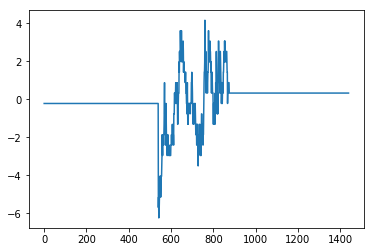

In [7]:
plt.plot(X_train[100])

In [8]:
# Convolutional Autoencoder
# with more Conv1D layers

$$new\ width(height) = \frac{width(height) - F + 2 \times P}{S} + 1$$

In [9]:
# input sequence
input_seq = Input(shape=(timesteps, input_dim))

# encoder with Conv1D and MaxPooling1D
X = Conv1D(filters=4, kernel_size=3, strides=1, padding='causal', activation='relu')(input_seq)
X = BatchNormalization()(X)
X = MaxPooling1D(6, padding='valid')(X)

X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = MaxPooling1D(6, padding='valid')(X)

X = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
encoded = MaxPooling1D(4, padding='valid')(X)

In [10]:
# decoder with Conv1D and UpSampling1D
X = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', activation='relu')(encoded)
X = BatchNormalization()(X)
X = Conv1D(filters=16, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(4)(X)

X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = Conv1D(filters=8, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(6)(X)

X = Conv1D(filters=4, kernel_size=3, strides=1, padding='causal', activation='relu')(X)
X = BatchNormalization()(X)
X = UpSampling1D(6)(X)
decoded = Conv1D(filters=1, kernel_size=3, strides=1, padding='causal', activation='sigmoid')(X)

In [11]:
Conv1DAuto_Simulation = Model(inputs=[input_seq], outputs=[decoded])

In [12]:
Conv1DAuto_Real = clone_model(Conv1DAuto_Simulation)

In [13]:
Conv1DAuto_Simulation.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1440, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1440, 4)           16        
_________________________________________________________________
batch_normalization_v2 (Batc (None, 1440, 4)           16        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 240, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 240, 8)            104       
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 240, 8)            32        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 240, 8)            200   

In [14]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('Conv1DAuto_Real.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [15]:
Conv1DAuto_Real.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [17]:
history_real = Conv1DAuto_Real.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid), verbose=False)

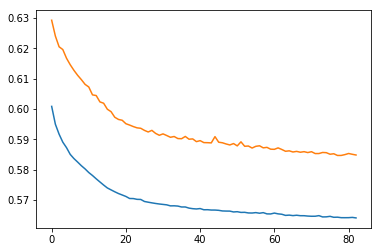

In [18]:
plt.plot(history_real.history['loss'])
plt.plot(history_real.history['val_loss'])

In [19]:
X_pred = Conv1DAuto_Real.predict(X_test)

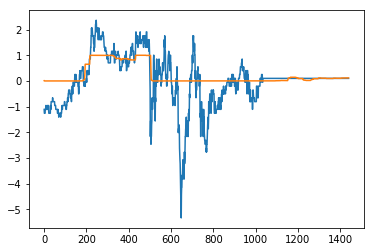

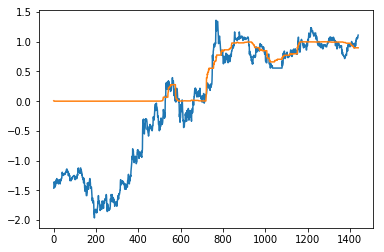

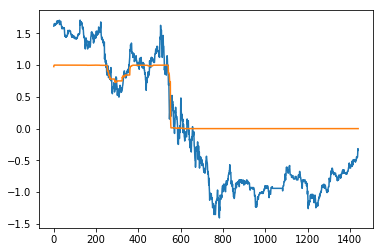

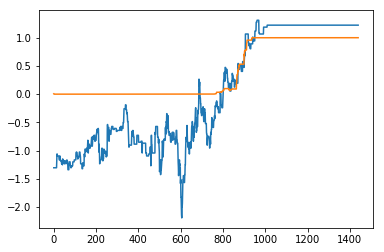

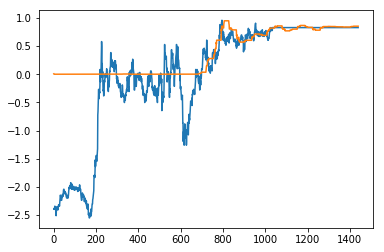

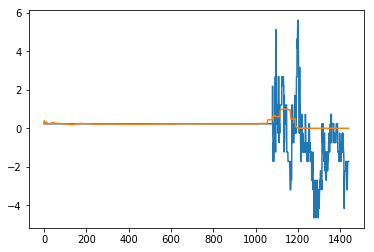

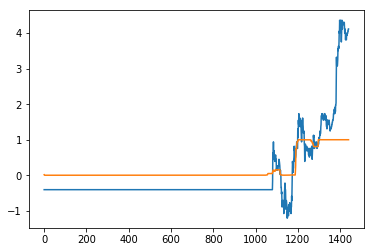

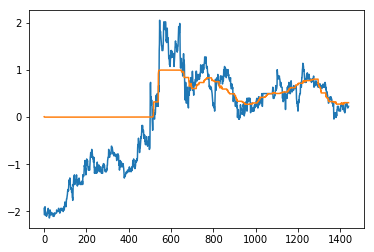

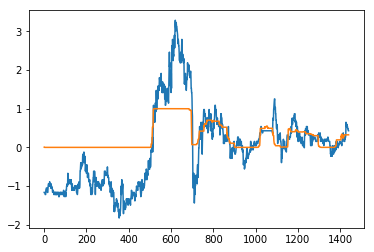

In [20]:
for i in range(len(X_pred)):
    if i % 120 == 0:
        plt.figure(figsize=(6,4))
        plt.plot(X_test[i])
        plt.plot(X_pred[i])

In [21]:
X_train, X_test, X_valid = load_simulation_data()

100%|███████████████████████████████████████████████████████████████████████████| 6000/6000 [00:00<00:00, 13962.16it/s]


In [22]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(4000, 1440, 1)
(1500, 1440, 1)
(500, 1440, 1)


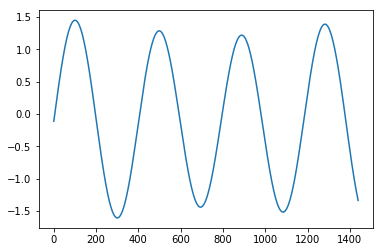

In [23]:
plt.plot(X_train[100])

In [24]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
                                  epsilon=None, decay=0.0, amsgrad=False)

checkpoint_cb = ModelCheckpoint('Conv1DAuto_Simulation.h5', save_best_only=True)

earlystopping_cb = EarlyStopping(patience=5)

In [25]:
Conv1DAuto_Simulation.compile(loss='mse', optimizer=optimizer,
                     metrics=['mse'])

In [26]:
history_simulation = Conv1DAuto_Simulation.fit(X_train, X_train, batch_size=batch_size, epochs=n_epochs,
                        callbacks=[checkpoint_cb, earlystopping_cb], 
                        validation_data=(X_valid, X_valid), verbose=False)

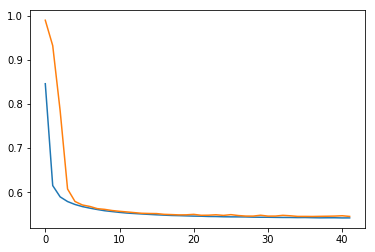

In [27]:
plt.plot(history_simulation.history['loss'])
plt.plot(history_simulation.history['val_loss'])

In [28]:
X_pred = Conv1DAuto_Simulation.predict(X_test)

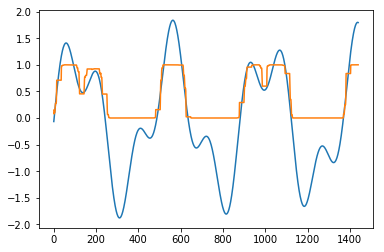

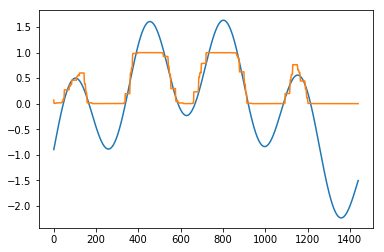

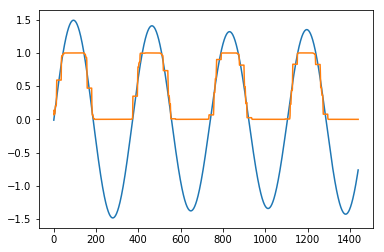

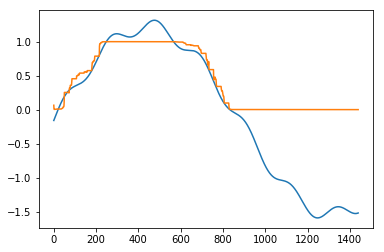

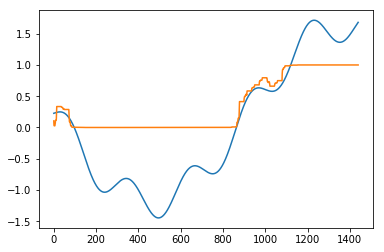

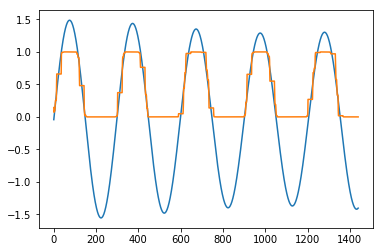

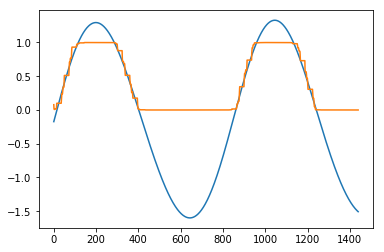

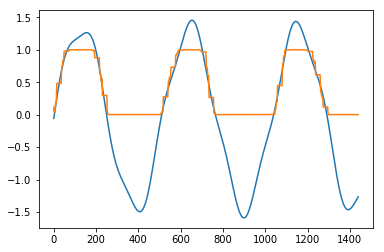

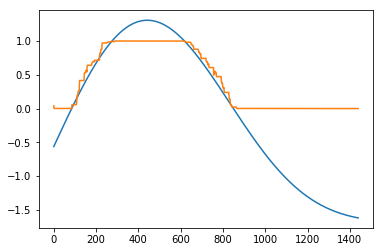

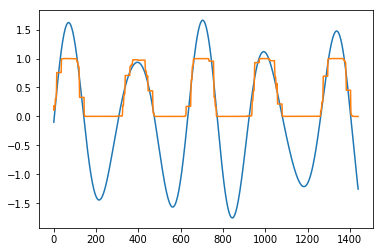

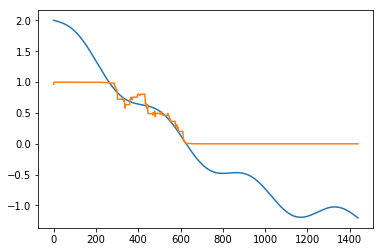

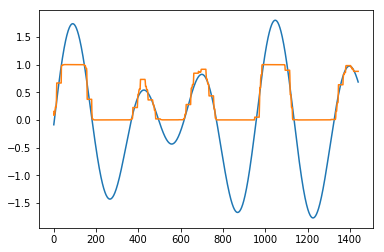

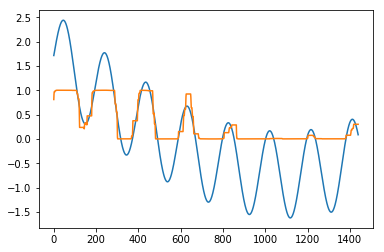

In [29]:
for i in range(len(X_pred)):
    if i % 120 == 0:
        plt.figure(figsize=(6,4))
        plt.plot(X_test[i])
        plt.plot(X_pred[i])